# Content Based Recommender

Reference:
* https://github.com/rounakbanik/movies

First built a simple movie recommender based on popularity and genres as well, but this is not personalized. The recommendations are the same for everyone. Then two content based recommender system are built based on different features:
* Movie Overviews and Taglines
* Movie Cast, Crew, Keywords and Genre

In [1]:
# import necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from nltk.stem.snowball import SnowballStemmer

%matplotlib inline

In [2]:
# Load datasets
md = pd.read_csv("data/movies_metadata.csv")
links_small = pd.read_csv('data/links_small.csv')
credits = pd.read_csv('data/credits.csv')
keywords = pd.read_csv('data/keywords.csv')

## Exploring data

In [3]:
# Metadata 
md.head().transpose()

,0,1,2,3,4
adult,False,False,False,False,False
backdrop_path,/dji4Fm0gCDVb9DQQMRvAI8YNnTz.jpg,/7k4zEgUZbzMHawDaMc9yIkmY1qR.jpg,/1ENbkuIYK2taNGGKNMs2hw6SaJb.jpg,/u0hQzp4xfag3ZhsKKBBdgyIVvCl.jpg,/cZs50rEk4T13qWedon0uCnbYQzW.jpg
belongs_to_collection,"{'id': 10194, 'name': 'Toy Story Collection', ...","{'id': 495527, 'name': 'Jumanji Collection', '...","{'id': 119050, 'name': 'Grumpy Old Men Collect...",NaN,"{'id': 96871, 'name': 'Father of the Bride Col..."
budget,3e+07,6.5e+07,0,1.6e+07,0
genres,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...","[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...","[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...","[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...","[{'id': 35, 'name': 'Comedy'}]"
homepage,http://toystory.disney.com/toy-story,NaN,NaN,NaN,NaN
id,862,8844,15602,31357,11862
imdb_id,tt0114709,tt0113497,tt0113228,tt0114885,tt0113041
original_language,en,en,en,en,en
original_title,Toy Story,Jumanji,Grumpier Old Men,Waiting to Exhale,Father of the Bride Part II


In [4]:
md.columns

Index(['adult', 'backdrop_path', 'belongs_to_collection', 'budget', 'genres',
       'homepage', 'id', 'imdb_id', 'original_language', 'original_title',
       'overview', 'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count'],
      dtype='object')

In [5]:
md.shape

(57396, 25)

In [6]:
md.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57396 entries, 0 to 57395
Data columns (total 25 columns):
adult                    57396 non-null object
backdrop_path            47399 non-null object
belongs_to_collection    5305 non-null object
budget                   57368 non-null float64
genres                   57368 non-null object
homepage                 9842 non-null object
id                       57368 non-null float64
imdb_id                  57355 non-null object
original_language        57368 non-null object
original_title           57368 non-null object
overview                 56167 non-null object
popularity               57368 non-null float64
poster_path              56924 non-null object
production_companies     57368 non-null object
production_countries     57368 non-null object
release_date             57254 non-null object
revenue                  57368 non-null float64
runtime                  55200 non-null float64
spoken_languages         57368 non-null ob

In [7]:
# keywords dataset
keywords.head()

,id,keywords
0,862,"[{'id': 779, 'name': 'martial arts'}, {'id': 9..."
1,8844,"[{'id': 7035, 'name': 'giant insect'}, {'id': ..."
2,15602,"[{'id': 1495, 'name': 'fishing'}, {'id': 10938..."
3,31357,"[{'id': 818, 'name': 'based on novel or book'}..."
4,11862,"[{'id': 970, 'name': 'parent child relationshi..."


In [8]:
keywords.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57367 entries, 0 to 57366
Data columns (total 2 columns):
id          57367 non-null int64
keywords    57367 non-null object
dtypes: int64(1), object(1)
memory usage: 896.4+ KB


In [9]:
# links_small dataframe
links_small.shape

(9742, 3)

In [10]:
links_small.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [11]:
# credits dataframe
credits.shape

(57389, 3)

In [12]:
credits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57389 entries, 0 to 57388
Data columns (total 3 columns):
id      57389 non-null int64
cast    57389 non-null object
crew    57368 non-null object
dtypes: int64(1), object(2)
memory usage: 1.3+ MB


In [13]:
credits.head()

,id,cast,crew
0,862,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de..."
1,8844,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7c7d', 'de..."
2,15602,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de..."
3,31357,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de..."
4,11862,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ecb', 'de..."


In [14]:
# Title and Overview wordclouds
from wordcloud import WordCloud, STOPWORDS

In [15]:
md['title'] = md['title'].astype('str')
md['overview'] = md['overview'].astype('str')

title_corpus = ' '.join(md['title'])
overview_corpus = ' '.join(md['overview'])

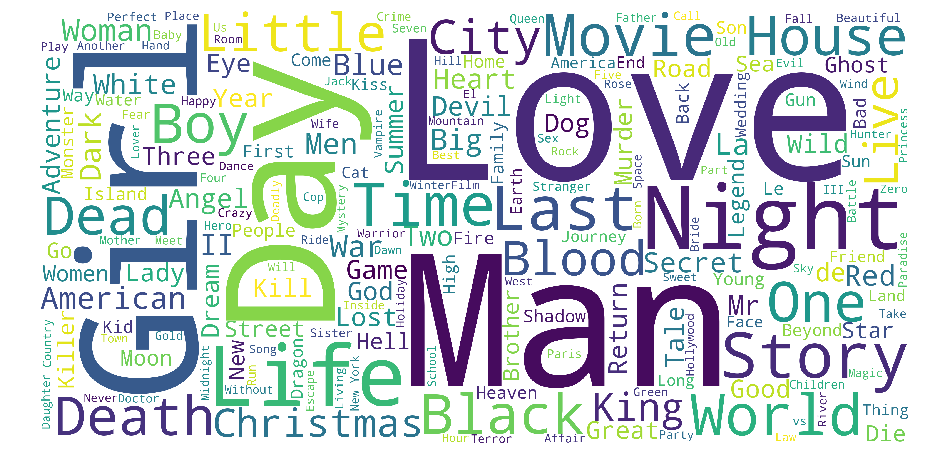

In [16]:
title_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white', 
                            height=2000, width=4000).generate(title_corpus)
plt.figure(figsize=(16,8))
plt.imshow(title_wordcloud)
plt.axis('off')
plt.show()

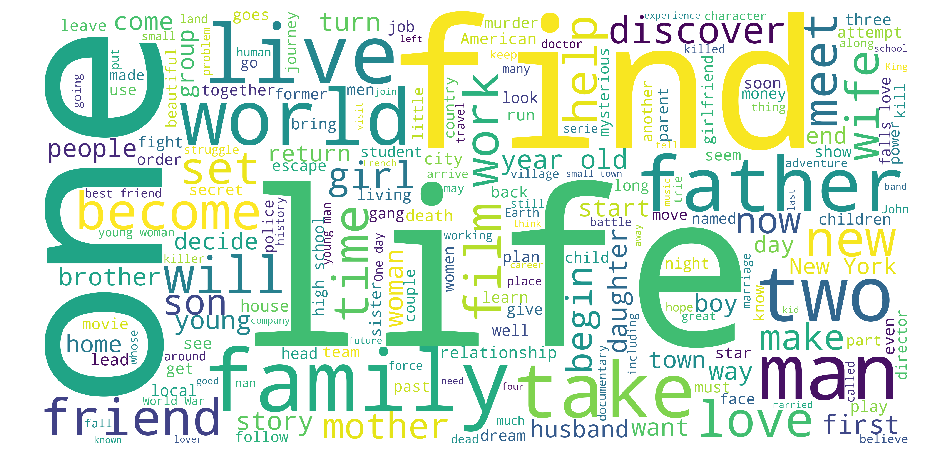

In [17]:
overview_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white', 
                               height=2000, width=4000).generate(overview_corpus)
plt.figure(figsize=(16,8))
plt.imshow(overview_wordcloud)
plt.axis('off')
plt.show()

## 1. Simple recommender based on popularity

In [18]:
md['genres'] = md['genres'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] 
                                                                   if isinstance(x, list) else [])

In [19]:
vote_counts = md[md['vote_count'].notnull()]['vote_count'].astype('int')
vote_averages = md[md['vote_average'].notnull()]['vote_average'].astype('int')
C = vote_averages.mean()
C

5.315001394505647

In [20]:
# for a movie to feature in the charts, it must have more votes than at least 95% of the movies in the list
m = vote_counts.quantile(0.95)
m

508.6499999999942

In [21]:
md['year'] = pd.to_datetime(md['release_date'], errors='coerce').apply(lambda x: str(x).split('-')[0] 
                                                                       if x != np.nan else np.nan)

In [22]:
qualified = md[(md['vote_count'] >= m) & (md['vote_count'].notnull()) & (md['vote_average'].notnull())
              ][['title', 'year', 'vote_count', 'vote_average', 'popularity', 'genres']]
qualified['vote_count'] = qualified['vote_count'].astype('int')
qualified['vote_average'] = qualified['vote_average'].astype('int')
qualified.shape

(2869, 6)

In [23]:
# IMDB's weighted rating formula 
# (v/(v+m) * R) + (m/(m+v) * C)
# v is the number of votes for the movie
# m is the minimum votes required to be listed in the chart
# R is the average rating of the movie
# C is the mean vote across the whole report

def weighted_rating(x):
    v = x['vote_count']
    R = x['vote_average']
    return (v/(v+m) * R) + (m/(m+v) * C)

In [24]:
qualified['wr'] = qualified.apply(weighted_rating, axis=1)

In [25]:
qualified = qualified.sort_values('wr', ascending=False).head(250)

In [26]:
qualified.head(15)

,title,year,vote_count,vote_average,popularity,genres,wr
10309,Dilwale Dulhania Le Jayenge,1995,1888,9,12.690,"[Comedy, Drama, Romance]",8.217919
15479,Inception,2010,18987,8,32.677,"[Action, Thriller, Science Fiction, Mystery, A...",7.929947
12478,The Dark Knight,2008,16277,8,35.187,"[Drama, Action, Crime, Thriller]",7.918637
22955,Interstellar,2014,15612,8,34.625,"[Adventure, Drama, Science Fiction]",7.915281
2851,Fight Club,1999,13778,8,31.278,[Drama],7.904406
20068,Django Unchained,2012,13522,8,24.685,"[Drama, Western]",7.902661
293,Pulp Fiction,1994,12662,8,29.558,"[Thriller, Crime]",7.896305
4873,The Lord of the Rings: The Fellowship of the Ring,2001,12269,8,40.335,"[Adventure, Fantasy, Action]",7.893116
2466,The Matrix,1999,12249,8,27.531,"[Action, Science Fiction]",7.892949
352,Forrest Gump,1994,12069,8,24.161,"[Comedy, Drama, Romance]",7.891417


In [27]:
#  Recommend top popular moveis based on Genre
s = md.apply(lambda x: pd.Series(x['genres']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'genre'
gen_md = md.drop('genres', axis=1).join(s)

In [28]:
gen_md.head().transpose()

,0,0,0,1,1
adult,False,False,False,False,False
backdrop_path,/dji4Fm0gCDVb9DQQMRvAI8YNnTz.jpg,/dji4Fm0gCDVb9DQQMRvAI8YNnTz.jpg,/dji4Fm0gCDVb9DQQMRvAI8YNnTz.jpg,/7k4zEgUZbzMHawDaMc9yIkmY1qR.jpg,/7k4zEgUZbzMHawDaMc9yIkmY1qR.jpg
belongs_to_collection,"{'id': 10194, 'name': 'Toy Story Collection', ...","{'id': 10194, 'name': 'Toy Story Collection', ...","{'id': 10194, 'name': 'Toy Story Collection', ...","{'id': 495527, 'name': 'Jumanji Collection', '...","{'id': 495527, 'name': 'Jumanji Collection', '..."
budget,3e+07,3e+07,3e+07,6.5e+07,6.5e+07
homepage,http://toystory.disney.com/toy-story,http://toystory.disney.com/toy-story,http://toystory.disney.com/toy-story,NaN,NaN
id,862,862,862,8844,8844
imdb_id,tt0114709,tt0114709,tt0114709,tt0113497,tt0113497
original_language,en,en,en,en,en
original_title,Toy Story,Toy Story,Toy Story,Jumanji,Jumanji
overview,"Led by Woody, Andy's toys live happily in his ...","Led by Woody, Andy's toys live happily in his ...","Led by Woody, Andy's toys live happily in his ...",When siblings Judy and Peter discover an encha...,When siblings Judy and Peter discover an encha...


In [29]:
def build_chart(genre, percentile=0.85):
    df = gen_md[gen_md['genre'] == genre]
    vote_counts = df[df['vote_count'].notnull()]['vote_count'].astype('int')
    vote_averages = df[df['vote_average'].notnull()]['vote_average'].astype('int')
    C = vote_averages.mean()
    m = vote_counts.quantile(percentile)
    
    qualified = df[(df['vote_count'] >= m) & (df['vote_count'].notnull()) & 
                   (df['vote_average'].notnull())][['title', 'year', 'vote_count', 'vote_average', 'popularity']]
    qualified['vote_count'] = qualified['vote_count'].astype('int')
    qualified['vote_average'] = qualified['vote_average'].astype('int')
    
    qualified['wr'] = qualified.apply(lambda x: (x['vote_count']/(x['vote_count']+m) * x['vote_average']) + 
                                      (m/(m+x['vote_count']) * C), axis=1)
    qualified = qualified.sort_values('wr', ascending=False).head(250)
    
    return qualified

In [30]:
# Top 15 Romance Movies
build_chart('Romance').head(15)

,title,year,vote_count,vote_average,popularity,wr
10309,Dilwale Dulhania Le Jayenge,1995,1888,9,12.690,8.799560
352,Forrest Gump,1994,12069,8,24.161,7.976555
7219,Eternal Sunshine of the Spotless Mind,2004,5923,8,17.048,7.952694
46189,Call Me by Your Name,2017,3335,8,29.750,7.917217
43786,Your Name.,2016,2933,8,16.879,7.906303
56422,To All the Boys I've Loved Before,2018,2133,8,38.364,7.872973
890,Casablanca,1942,2097,8,13.833,7.870907
53666,"Love, Simon",2018,1990,8,18.957,7.864348
881,Vertigo,1958,1924,8,12.589,7.859959
1138,Cinema Paradiso,1988,1331,8,10.851,7.802569


In [31]:
# Top 15 Science Fiction Movies
build_chart('Science Fiction').head(15)

,title,year,vote_count,vote_average,popularity,wr
15479,Inception,2010,18987,8,32.677,7.948276
22955,Interstellar,2014,15612,8,34.625,7.937324
2466,The Matrix,1999,12249,8,27.531,7.920563
257,Star Wars,1977,9785,8,39.626,7.901207
1231,Back to the Future,1985,9125,8,26.533,7.894309
1160,The Empire Strikes Back,1980,8453,8,16.187,7.886219
27176,Avengers: Infinity War,2018,8431,8,155.869,7.885933
1173,Return of the Jedi,1983,6931,8,16.438,7.862359
1177,Alien,1979,6357,8,22.670,7.850539
7219,Eternal Sunshine of the Spotless Mind,2004,5923,8,17.048,7.840161


In [32]:
# Top 15 Crime Movies
build_chart('Crime').head(15)

,title,year,vote_count,vote_average,popularity,wr
12478,The Dark Knight,2008,16277,8,35.187,7.966666
293,Pulp Fiction,1994,12662,8,29.558,7.957311
315,The Shawshank Redemption,1994,11104,8,31.540,7.951438
46,Se7en,1995,8740,8,20.086,7.938625
838,The Godfather,1972,8484,8,27.980,7.936820
587,The Silence of the Lambs,1991,6923,8,4.401,7.923013
3038,The Green Mile,1999,6548,8,23.687,7.918747
11316,The Departed,2006,6481,8,19.864,7.917935
290,Leon: The Professional,1994,6309,8,24.484,7.915773
1062,Reservoir Dogs,1992,5833,8,17.365,7.909150


## 2. Content Based Recommender

In [33]:
links_small = links_small[links_small['tmdbId'].notnull()]['tmdbId'].astype('int')

In [34]:
## Pre-processing step
def convert_int(x):
    try:
        return int(x)
    except:
        return np.nan

In [35]:
md['id'] = md['id'].apply(convert_int)
md[md['id'].isnull()]

,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,...,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,year
1387,34,The resource you requested could not be found.,NaN,NaN,[],NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,nan,NaN,NaN,NaN,NaT
4089,34,The resource you requested could not be found.,NaN,NaN,[],NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,nan,NaN,NaN,NaN,NaT
4449,34,The resource you requested could not be found.,NaN,NaN,[],NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,nan,NaN,NaN,NaN,NaT
7003,34,The resource you requested could not be found.,NaN,NaN,[],NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,nan,NaN,NaN,NaN,NaT
9066,34,The resource you requested could not be found.,NaN,NaN,[],NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,nan,NaN,NaN,NaN,NaT
9183,34,The resource you requested could not be found.,NaN,NaN,[],NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,nan,NaN,NaN,NaN,NaT
9417,34,The resource you requested could not be found.,NaN,NaN,[],NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,nan,NaN,NaN,NaN,NaT
10420,34,The resource you requested could not be found.,NaN,NaN,[],NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,nan,NaN,NaN,NaN,NaT
13470,34,The resource you requested could not be found.,NaN,NaN,[],NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,nan,NaN,NaN,NaN,NaT
15075,34,The resource you requested could not be found.,NaN,NaN,[],NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,nan,NaN,NaN,NaN,NaT


In [36]:
md = md.drop(md[md['id'].isnull()].index)

In [37]:
md['id'] = md['id'].astype('int')

In [38]:
# Wordking on the smaller dataset beacuase of the limiting computing power 
# use .copy() to prevent SettingWithCopyWarning
smd = md.loc[md['id'].isin(links_small)].copy()
smd.shape

(9651, 26)

### 2.1 Content Based RecSys: Movie Overviews and Taglines

In [39]:
smd['tagline'] = smd['tagline'].fillna('')
smd['description'] = smd['overview'] + smd['tagline']
smd['description'] = smd['description'].fillna('')

Using TF-IDF

In [40]:
tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(smd['description'])

In [41]:
tfidf_matrix.shape

(9651, 276338)

In [42]:
# Cosine similarity
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [43]:
smd = smd.reset_index()
titles = smd['title']
indices = pd.Series(smd.index, index=smd['title'])

In [44]:
def get_recommendations(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:31]
    movie_indices = [i[0] for i in sim_scores]
    return titles.iloc[movie_indices]

In [45]:
# Top 10 movies similar to 'The Godfather'
get_recommendations('The Godfather').head(10)

9454    The Godfather Trilogy: 1972-1990
921               The Godfather: Part II
8195                          The Family
3288                                Made
3944                  Johnny Dangerously
29                        Shanghai Triad
2264                      American Movie
4599                            Mobsters
8000                   Playing for Keeps
1497             The Godfather: Part III
Name: title, dtype: object

In [46]:
# Top 10 movies similar to 'The Dark Knight'
get_recommendations('The Dark Knight').head(10)

7716                      The Dark Knight Rises
126                              Batman Forever
1059                             Batman Returns
8018    Batman: The Dark Knight Returns, Part 2
7335                 Batman: Under the Red Hood
509                                      Batman
9369                      The Lego Batman Movie
7681                           Batman: Year One
5609         Batman Beyond: Return of the Joker
2524                                        JFK
Name: title, dtype: object

### 2.2 Content Based RecSys: Movie Cast, Crew, Keywords and Genre

In [47]:
keywords['id'] = keywords['id'].astype('int')
credits['id'] = credits['id'].astype('int')
md['id'] = md['id'].astype('int')

In [48]:
md = md.merge(credits, on='id')
md = md.merge(keywords, on='id')

In [49]:
smd = md.loc[md['id'].isin(links_small)].copy()
smd.shape

(9729, 29)

In [50]:
smd['cast'] = smd['cast'].apply(literal_eval)
smd['crew'] = smd['crew'].apply(literal_eval)
smd['keywords'] = smd['keywords'].apply(literal_eval)
smd['cast_size'] = smd['cast'].apply(lambda x: len(x))
smd['crew_size'] = smd['crew'].apply(lambda x: len(x))

In [51]:
def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan

In [52]:
smd['director'] = smd['crew'].apply(get_director)
smd['cast'] = smd['cast'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
# top 3 casts
smd['cast'] = smd['cast'].apply(lambda x: x[:3] if len(x) >=3 else x)
smd['keywords'] = smd['keywords'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

In [53]:
smd['cast'] = smd['cast'].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])
smd['director'] = smd['director'].astype('str').apply(lambda x: str.lower(x.replace(" ", "")))
smd['director'] = smd['director'].apply(lambda x: [x, x]) # give director more weights

In [54]:
s = smd.apply(lambda x: pd.Series(x['keywords']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'keyword'
s = s.value_counts()
s[:5]

woman director            578
based on novel or book    510
independent film          495
murder                    439
duringcreditsstinger      334
Name: keyword, dtype: int64

In [55]:
s = s[s > 1]

In [56]:
def filter_keywords(x):
    words = []
    for i in x:
        if i in s:
            words.append(i)
    return words

In [57]:
stemmer = SnowballStemmer('english')
smd['keywords'] = smd['keywords'].apply(filter_keywords)
smd['keywords'] = smd['keywords'].apply(lambda x: [stemmer.stem(i) for i in x])
smd['keywords'] = smd['keywords'].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])

In [58]:
smd['soup'] = smd['keywords'] + smd['cast'] + smd['director'] + smd['genres']
smd['soup'] = smd['soup'].apply(lambda x: ' '.join(x))

In [59]:
count = CountVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
count_matrix = count.fit_transform(smd['soup'])

In [60]:
cosine_sim = cosine_similarity(count_matrix, count_matrix)

In [61]:
smd = smd.reset_index()
titles = smd['title']
indices = pd.Series(smd.index, index=smd['title'])

In [62]:
get_recommendations('The Dark Knight').head(10)

7803         The Dark Knight Rises
5958                 Batman Begins
7422    Batman: Under the Red Hood
6377                  The Prestige
8505     Batman: Assault on Arkham
8811       Kidnapping Mr. Heineken
9357      Batman: The Killing Joke
5659                      Thursday
1073                Batman Returns
8260                    Kick-Ass 2
Name: title, dtype: object

In [63]:
get_recommendations('Inception').head(10)

3431                        Jurassic Park III
5387    Sky Captain and the World of Tomorrow
2020                     The Thirteenth Floor
4687                   The Matrix Revolutions
4327                                 The Core
4392                      The Matrix Reloaded
1973                                 eXistenZ
3900                          Minority Report
9265                                Project X
8006                                   Looper
Name: title, dtype: object

In [64]:
# including popularity and ratings using IMDB's weighted rating formula
def improved_recommendations(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:26]
    movie_indices = [i[0] for i in sim_scores]
    
    movies = smd.iloc[movie_indices][['title', 'vote_count', 'vote_average', 'year']]
    vote_counts = movies[movies['vote_count'].notnull()]['vote_count'].astype('int')
    vote_averages = movies[movies['vote_average'].notnull()]['vote_average'].astype('int')
    C = vote_averages.mean()
    m = vote_counts.quantile(0.60)
    qualified = movies.loc[(movies['vote_count'] >= m) & (movies['vote_count'].notnull()) & 
                       (movies['vote_average'].notnull())].copy()
    qualified['vote_count'] = qualified['vote_count'].astype('int')
    qualified['vote_average'] = qualified['vote_average'].astype('int')
    qualified['wr'] = qualified.apply(weighted_rating, axis=1)
    qualified = qualified.sort_values('wr', ascending=False).head(10)
    return qualified

In [65]:
improved_recommendations('The Dark Knight')

,title,vote_count,vote_average,year,wr
6377,The Prestige,6734,8,2006,7.811433
7803,The Dark Knight Rises,12119,7,2012,6.932127
5958,Batman Begins,10414,7,2005,6.921532
7422,Batman: Under the Red Hood,659,7,2010,6.265983
8260,Kick-Ass 2,3186,6,2013,5.905695
1073,Batman Returns,2581,6,1992,5.887228
7908,Safe,1045,6,2012,5.775738
9357,Batman: The Killing Joke,716,6,2016,5.715491
4270,Daredevil,2353,5,2003,5.055991
8976,Batman v Superman: Dawn of Justice,10337,5,2016,5.014773


In [66]:
improved_recommendations('Pulp Fiction')

,title,vote_count,vote_average,year,wr
7050,Inglourious Basterds,9799,8,2009,7.867504
842,Reservoir Dogs,5833,8,1992,7.784642
4663,Kill Bill: Vol. 1,7671,7,2003,6.895219
8771,The Hateful Eight,6560,7,2015,6.878750
4983,Kill Bill: Vol. 2,6101,7,2004,6.870330
1307,Jackie Brown,2465,7,1997,6.711777
6551,Death Proof,1976,6,2007,5.859769
6380,Saw III,1830,6,2006,5.851015
7390,Unthinkable,541,6,2010,5.668056
4508,S.W.A.T.,1046,5,2003,5.103062
